# STAT 248 Final Project: Smoothed Poisson Model for Imputing Hourly Rainfall

- **Name**: Connor McCaffrey
- **email**: connormc@berkeley.edu

## Overview

In this notebook, I fit a smoothed Poisson model to hourly rainfall data from two weather stations: "XOIC1" and "KNNC1." These stations were selected from a pool of several thousand for their high data quality. In particular, "XOIC1" was chosen for its proximity to many other reliable stations, which makes it especially useful for validation and comparison.

Part 1 focuses on modeling the "XOIC1" data. I begin by fitting smoothed Poisson models with both ridge and LASSO penalties. Based on visual inspection of the fits, I find that the ridge-penalized model performs better. I then hold out a test set and use 5-fold cross-validation to identify two plausible values for the ridge penalty parameter, $\lambda$. Using these two values, I evaluate test-set performance against several metrics and compare results to a baseline model based on hourly averages from neighboring stations. Finally, I assess robustness by refitting the model with different “leave-out” schemes (e.g., leaving out 1 hour, 2 consecutive hours, 12 consecutive hours, etc.) and comparing performance across these real-life imputation scenarios.

Part 2 turns to the "KNNC1" station, where I attempt uncertainty quantification using data from 2014. Although the station has a full 10-year record, I restrict the analysis to the first 12 months for computational feasability. This limitation is especially important because the two uncertainty quantification methods I apply (the Fisher information-based normal approximation and bootstrap percentile-based confidence intervals) can become very computationally expensive. I begin with 5-fold cross-validation for both ridge and LASSO models (this time without a separate test set), again finding ridge to yield a better fit. I then use the selected model to compute 95% confidence intervals for the fitted parameters.

## Poisson Model

### Assumptions

We can model hourly rainfall using:

$$y_i \sim Poisson(\theta_i), \qquad i = 1, ..., n$$

where:

- $y_i$ is the observed rainfall in hour $i$, typically discretized such that $y_i \in \mathbb{N}_0$
  
- $\theta_i \in (0, \infty)$ is the unknown rate parameter of the Poisson distribution for each hour $i$

Recall the basic properties of the Poisson distribution:

- pmf $p_{\theta_i}(y_i) = \frac{\theta_i^{y_i} e^{-\theta_i}}{y_i!}$

- $E[y_i] = \theta_i$

- $Var(y_i) = \theta_i$

### Unregularized MLE

We will want to derive the maximum likelihood estimator (MLE) for this data $\hat{\theta}_{MLE} = \left(\hat{\theta}_1, ..., \hat{\theta}_n \right)$. For independent observations, we can derive the joint likelihood as

$$L(\theta_1, ..., \theta_n) = \prod^n_{i=1} p_{\theta_i}(y_i) = \prod^n_{i=1} \theta_i^{y_i} \exp(-\theta_i) (y_i!)^{-1}$$

$$\ell(\theta_1, ..., \theta_n) = \log L(\theta_1, ..., \theta_n) = \sum^n_{i=1} \left[ y_i \log \theta_i - \theta_i - \log(y_i!) \right]$$

$$\hat{\theta}_{MLE} = \text{arg max}_{\theta_1, ..., \theta_n} \ell(\theta_1, ..., \theta_n) = \text{arg max}_{\theta_1, ..., \theta_n} \sum^n_{i=1} \left[ y_i \log \theta_i - \theta_i \right]$$

We maximize $\ell(\theta_1, ..., \theta_n)$ over all $\theta_i$ independently. That is, we can take derivatives w.r.t each $\theta_i$:

$$\frac{\partial \ell}{\partial \theta_i} = \frac{y_i}{\theta_i} - 1 = 0 \implies \hat{\theta}_i = y_i$$

Thus, the unregularized MLE simply sets $\hat{\theta}_i = y_i$. This is a saturated high-dimensional model that recovers the data exactly. This isn't useful for several reasons:

- doesn't generalize or denoise the data

- doesn't model structure or temporal trends (e.g., seasonality, rainfall bursts, dry spells)

- zero bias but high variance estimates

### Adding Regularization

This is where regularization becomes valuable. Regularization shrinks noisy estimates toward their neighbors:

- reduces variance by trading off a little bias, improving generalization

- lets us recover underlying signal

- pulling strength from nearby observations is useful for imputing missing values


The penalized log-likelihood problem becomes

$$\hat{\theta} = \text{arg max}_{\theta_1, ..., \theta_n} \left[ \sum^n_{i=1} (y_i \log \theta_i - \theta_i) - \lambda \cdot \text{Penalty}(\theta) \right]$$

or equivalently

$$\hat{\theta} = \text{arg min}_{\theta_1, ..., \theta_n} \left[ \sum^n_{i=1} (\theta_i - y_i \log \theta_i) + \lambda \cdot \text{Penalty}(\theta) \right]$$

where $\lambda \geq 0$ controls the strength of the penalty and the smoothing.

### Choice of Smoothness Penalty

The choice of  $\text{Penalty}(\theta)$ determines the structure the model prefers:

- First-order difference: $\sum^{n-1}_{i=1} (\theta_{i+1} - \theta_i)^2$
    - encourages local flatness (adjacent $\theta_i$'s should be close)
    - useful when rainfall levels are expected to change gradually over time.
- Second-order difference: $\sum^{n-1}_{i=2} \left((\theta_{i+1} - \theta_i) - (\theta_i - \theta_{i-1}) \right)^2$
    - encourages linear trends over small windows (i.e., where rain increases/decreases linearly)
- First-order difference on log scale: $\sum^{n-1}_{i=1} \left( \eta_{i+1} - \eta_i \right)^2$ where $\eta_i = \log \theta_i$
    - encourges smooth relative changes, not absolute ones
    - more appropriate when rainfall rates vary over orders of magnitude
    - ***this is the primary penalty we will be using***
- First-order total variation: $\sum^{n-1}_{i=1} | \theta_{i+1} - \theta_i |$
    - encourages piecewise constant structure (long flat segments with abrupt jumps)
    - useful if rainfall tends to be stable for long periods, with occasional shifts
- First-order total variation on log scale: $\sum^{n-1}_{i=1} | \eta_{i+1} - \eta_i |$ where $\eta_i = \log \theta_i$
    - encourages multiplicative pleateaus with occasional jumps
    - captures regime changes in relative rainfall levels
- Other ideas?
    - Penalized spline smoothers
    - Gaussian process prior

### Optimization Problem

If we choose first-order differences on the log scale as our smoothness penalty, the objective function to minimize becomes the following. This formulation uses a ridge penalty (i.e., sum of squares or $L_2$ norm).

$$Obj = \text{arg min}_{\theta_1, ..., \theta_n} \left[ \sum^n_{i=1} (\theta_i - y_i \eta_i) + \lambda \sum^{n-1}_{i=1} ( \eta_{i+1} - \eta_i )^2 \right]$$

Alternatively, we can use a LASSO penalty (i.e., sum of absolute values or $L_1$ norm) for comparison:

$$Obj = \text{arg min}_{\theta_1, ..., \theta_n} \left[ \sum^n_{i=1} (\theta_i - y_i \eta_i) + \lambda \sum^{n-1}_{i=1} | \eta_{i+1} - \eta_i | \right]$$

## Discussion of Results

### Part 1: Imputation Performance for "XOIC1" Data

Based on a visual assessment of the fit, the smoothed estimates produced using a ridge penalty generally outperform those from a LASSO penalty. Using 5-fold cross-validation, we identify $\lambda_1 = 0.016$ and $\lambda_5 = 0.113$ as the top-performing values of the ridge regularization parameter. Across all evaluation metrics, both ridge models perform similarly.

To evaluate imputation accuracy, we randomly mask $10\%$ of observed values to simulate missingness. On this test set, our model achieves a root mean square error (RMSE) of approximately $0.52 \, \text{mm}$ and a mean absolute error (MAE) of about $0.08 \, \text{mm}$. For comparison, a baseline method that imputes using the hourly average rainfall from neighboring stations yields an RMSE of $0.75 \, \text{mm}$ and MAE of $0.12 \, \text{mm}$.

When reframed as a classification problem—predicting whether rainfall exceeds $0.01 \, \text{in}$ ($0.254 \, \text{mm}$) per hour (i.e., the binary "wet flag" threshold)—our model achieves a $2.0\%$ classification error rate with a true positive rate (TPR) of $75\%$. In contrast, the neighbor-based baseline results in a $4.6\%$ error rate and only $37\%$ TPR.

However, performance deteriorates when we simulate blocks of missing data instead of isolated missing values. Specifically, we modify the test set by masking contiguous segments of length $n$ (i.e., $n=1,2,6,12,24,48$). As $n$ increases, the model's performance declines, while the relative performance of the neighbor-based imputation improves. Nonetheless, for shorter gaps ($n < 6$), the smoothed Poisson model consistently outperforms the neighbor baseline.

### Part 2: Uncertainty Quantification for "KNNC1" Data

Due to computational constraints, we restrict analysis to the first year of data. Using this subset, we estimate the optimal ridge penalty parameter as $\lambda = 0.48$ vua 5-fold cross-validation. Our focus in this section is not on prediction performance, but rather on quantifying uncertainty in the model's fitted values.

We compute two types of $95\%$ confidence intervals: (1) approximate normal intervals derived from the Fisher information matrix, and (2) parametric bootstrap percentile intervals. The Fisher information-based interval upper bounds explode during long dry spells due to the flatness of the log-likelihood in regions  with many consecutive zero-rainfall hours, which leads to poor curvature and inflated standard errors. Additionally, this method requires inverting the Fisher information matrix, which is computationally intensive.

The parametric bootstrap percentile intervals tend to be narrower and more stable, providing more realistic estimates of uncertainty. However, this method requires refitting the model for each of $B$ bootstrap resamples, substantially increasing computational demands. As a result, the precision of these intervals is limited by the number of bootstrap samples we can feasibly compute.

## Code Demonstration

### Load Packages & Data

In [22]:
# load packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.linalg import inv
from scipy.stats import norm
from pprint import pprint
import math

In [2]:
# load precipitatoin data for two stations
station_KNNC1 = pd.read_csv("station-KNNC1.csv")
station_XOIC1 = pd.read_csv("station-XOIC1.csv")

# extract hourly precipitation values
y_KNNC1 = station_KNNC1.iloc[:, 2].values
y_XOIC1 = station_XOIC1.iloc[:, 2].values

# extract timestamps
t_KNNC1 = station_KNNC1.iloc[:, 1].values.astype('datetime64[ns]')
t_XOIC1 = station_XOIC1.iloc[:, 1].values.astype('datetime64[ns]')

# for station XOIC1, extract hourly neighbor statistics:
# hourly mean and rolling median from neighboring stations
mean_neighbor_XOIC1 = station_XOIC1.iloc[:, 7].values
med_neighbor_XOIC1 = station_XOIC1.iloc[:, 11].values

# get number of hourly observations at each station
n_KNNC1 = len(y_KNNC1)
n_XOIC1 = len(y_XOIC1)

/tmp/ipykernel_680274/1959240758.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  t_KNNC1 = station_KNNC1.iloc[:, 1].values.astype('datetime64[ns]')
/tmp/ipykernel_680274/1959240758.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  t_XOIC1 = station_XOIC1.iloc[:, 1].values.astype('datetime64[ns]')


In [4]:
def clean(y):
    """
    Clean precipitation data by masking invalid values.
    
    Parameters:
        y (np.ndarray): Array of precipitation observations.
    
    Returns:
        tuple: 
            - y_clean (np.ndarray): Copy of `y` with invalid values replaced by np.nan.
            - obs_mask (np.ndarray): Boolean array where True indicates a valid observation.
    
    Notes:
        Valid values are:
        - Not NaN
        - Finite
        - Greater than or equal to 0
    """
    obs_mask = (~np.isnan(y) & np.isfinite(y) & (y >= 0))
    y_clean = np.where(obs_mask, y, np.nan)
    return y_clean, obs_mask

In [5]:
# clean raw precipitation data
y_clean_KNNC1, KNNC1_mask = clean(y_KNNC1)
y_clean_XOIC1, XOIC1_mask = clean(y_XOIC1)

# clean neighbor satistics (mean and median)
mean_neighbor_clean, mean_neighbor_mask = clean(mean_neighbor_XOIC1)
med_neighbor_clean, med_neighbor_mask = clean(med_neighbor_XOIC1)

In [8]:
# compare the number of total entries to the number of valid entries
print(len(y_KNNC1), np.sum(KNNC1_mask))
print(len(y_XOIC1), np.sum(XOIC1_mask))

93504 93341
19975 19936


### Part 1: Imputation Performance for "XOIC1" Data

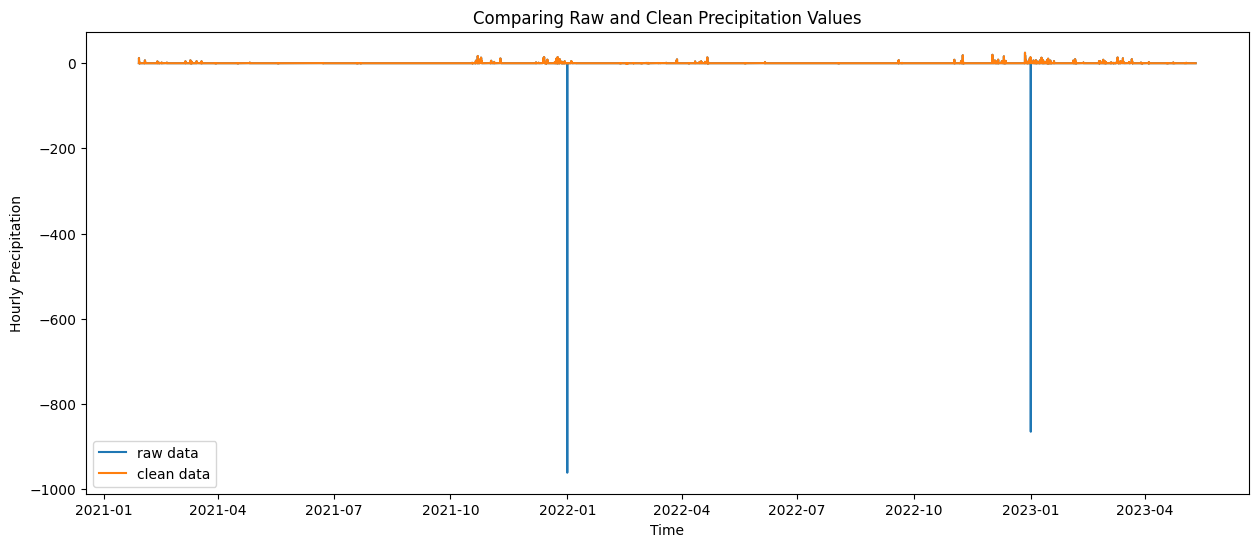

In [20]:
# visualize difference between raw and cleaned data for XOIC1
plt.figure(figsize = (15, 6))
plt.plot(t_XOIC1, y_XOIC1, label="raw data")
plt.plot(t_XOIC1, y_clean_XOIC1, label="clean data")
plt.xlabel('Time')
plt.ylabel('Hourly Precipitation')
plt.title('Comparing Raw and Clean Precipitation Values')
plt.legend()
plt.show()

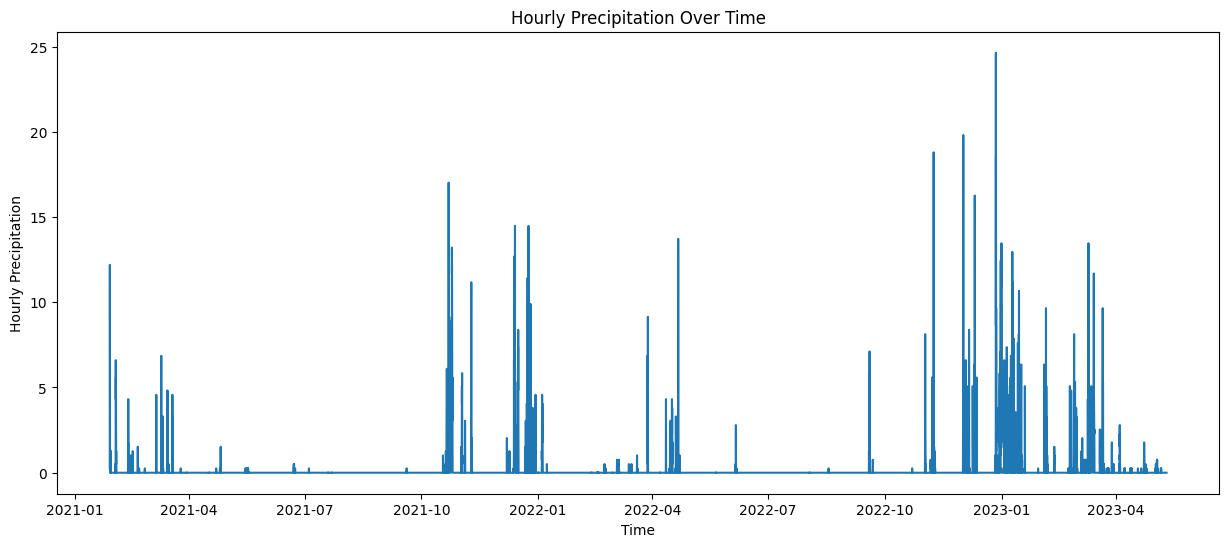

In [21]:
# plot clean precipitation data over time
plt.figure(figsize = (15, 6))
plt.plot(t_XOIC1, y_clean_XOIC1)
plt.xlabel('Time')
plt.ylabel('Hourly Precipitation')
plt.title('Hourly Precipitation Over Time')
plt.show()

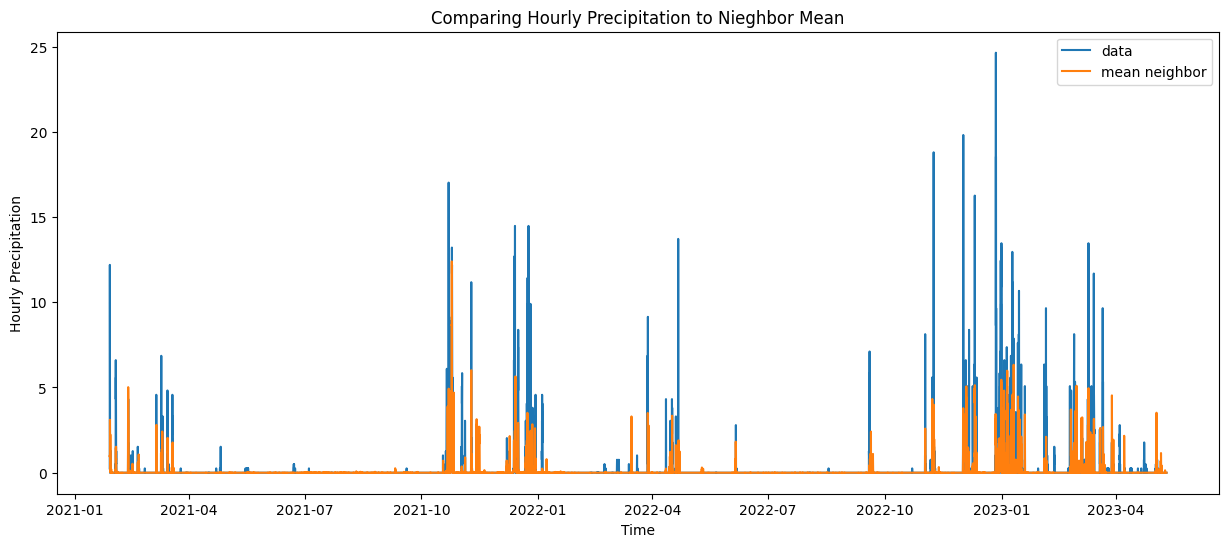

In [6]:
# compare cleaned data to mean neighbor values
plt.figure(figsize = (15, 6))
plt.plot(t_XOIC1, y_clean_XOIC1, label="data")
plt.plot(t_XOIC1, mean_neighbor_clean, label="mean neighbor")
plt.xlabel('Time')
plt.ylabel('Hourly Precipitation')
plt.title('Comparing Hourly Precipitation to Nieghbor Mean')
plt.legend()
plt.show()

In [7]:
# define function for Poisson smoothing with ridge or lasso penalty
def fit_poisson_smooth(y, obs_mask, penalty="ridge", lam=1.0, max_iters=5000):
    """
    Fit a Poisson model with a smoothness penalty on the log of the rate (eta = log theta).
    Missing values in y are handled via the obs_mask.

    Parameters:
    - y: array-like, observed counts (can contain np.nan for missing values)
    - obs_mask: boolean array indicating which entries are observed
    - penalty: str, "ridge" (L2) or "lasso" (L1) smoothness penalty
    - lam: float, regularization strength
    - max_iters: int, maximum number of iterations for solver

    Returns:
    - eta_hat: array, estimated log-rates (log of Poisson mean)
    """
    n = len(y)
    eta = cp.Variable(n) # log of Poisson rates

    y_obs = y[obs_mask] # observed y values only
    
    # define poisson nllh (up to a constant)
    log_likelihood = cp.sum(cp.exp(eta[obs_mask]) - cp.multiply(y_obs, eta[obs_mask]))

    # smoothness penalty on the first differences of eta
    if penalty == 'ridge':
        smooth_penalty = cp.sum_squares(eta[1:] - eta[:-1])
    elif penalty == 'lasso':
        smooth_penalty = cp.norm(eta[1:] - eta[:-1], 1)
    else:
        raise ValueError(f"Penalty must be 'ridge' or 'lasso', was {penalty}")

    
    # define and solve the optimization problem
    obj = cp.Minimize(log_likelihood + lam * smooth_penalty)
    prob = cp.Problem(obj)
    prob.solve(solver=cp.SCS, max_iters=max_iters)

    return eta.value # estimated log-rates

In [35]:
# fit the model with various lambda values for ridge penalty
eta_hat_XOIC1_ridge_1 = fit_poisson_smooth(y_clean_XOIC1, XOIC1_mask, "ridge", lam=1.0)
eta_hat_XOIC1_ridge_10 = fit_poisson_smooth(y_clean_XOIC1, XOIC1_mask, "ridge", lam=10.0)
eta_hat_XOIC1_ridge_100 = fit_poisson_smooth(y_clean_XOIC1, XOIC1_mask, "ridge", lam=100.0)

# fit the model with various lambda values for lasso penalty
eta_hat_XOIC1_lasso_1 = fit_poisson_smooth(y_clean_XOIC1, XOIC1_mask, "lasso", lam=1.0)
eta_hat_XOIC1_lasso_10 = fit_poisson_smooth(y_clean_XOIC1, XOIC1_mask, "lasso", lam=10.0)
eta_hat_XOIC1_lasso_100 = fit_poisson_smooth(y_clean_XOIC1, XOIC1_mask, "lasso", lam=100.0)

/accounts/grad/connormc/.local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


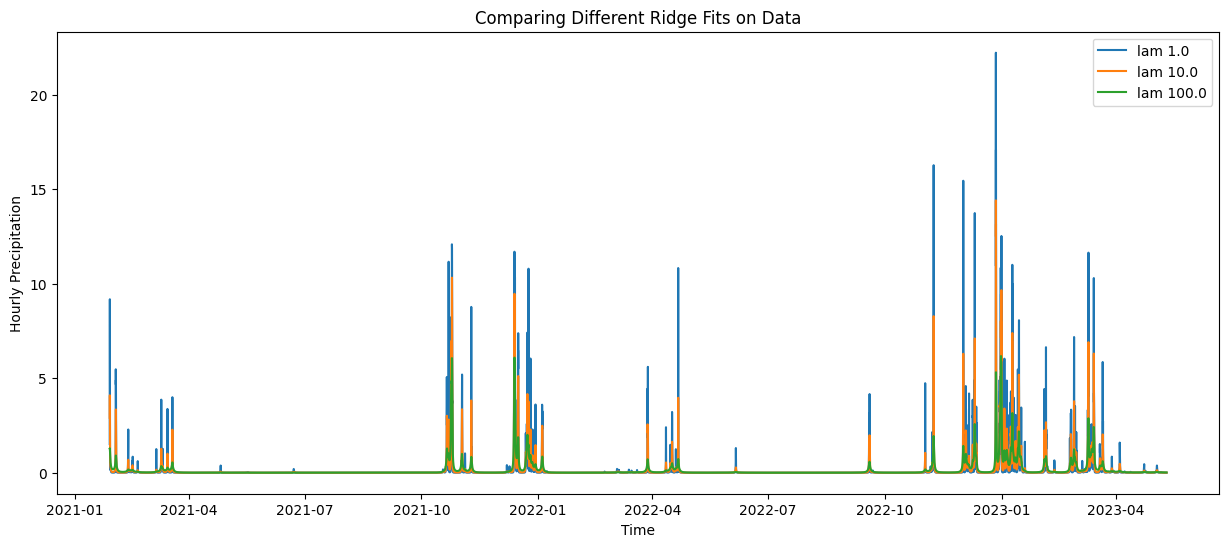

In [38]:
# plot the smoothed Poisson fits for ridge penalty across lambda values
plt.figure(figsize = (15, 6))
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_ridge_1), label="lam 1.0")
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_ridge_10), label="lam 10.0")
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_ridge_100), label="lam 100.0")

# optionally include original data (just overlaps with lambda=1.0)
#plt.plot(t_XOIC1, y_clean_XOIC1, label="clean data")

plt.xlabel('Time')
plt.ylabel('Hourly Precipitation')
plt.title('Comparing Different Ridge Fits on Data')
plt.legend()
plt.show()

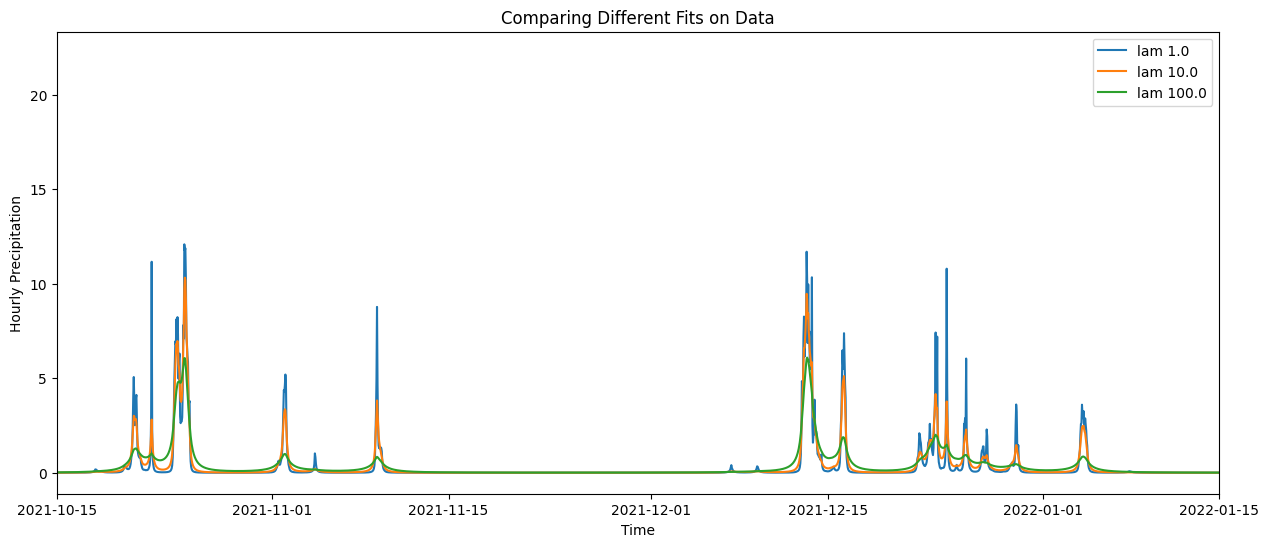

In [34]:
# rescale x-axis frm previous plot
plt.figure(figsize = (15, 6))
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_ridge_1), label="lam 1.0")
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_ridge_10), label="lam 10.0")
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_ridge_100), label="lam 100.0")
#plt.plot(t_XOIC1, y_clean_XOIC1, label="clean data")
plt.xlim(pd.Timestamp("2021-10-15"), pd.Timestamp("2022-01-15"))
plt.xlabel('Time')
plt.ylabel('Hourly Precipitation')
plt.title('Comparing Different Rige Fits on Data')
plt.legend()
plt.show()

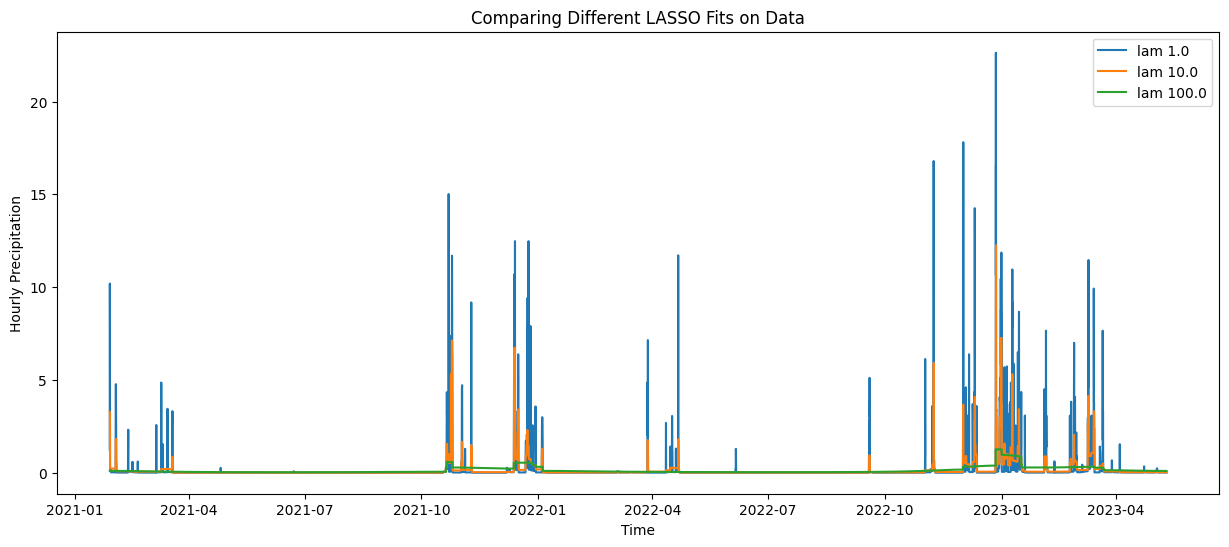

In [39]:
# plot LASSO smoothed Poisson estimates across lambda values
plt.figure(figsize = (15, 6))
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_lasso_1), label="lam 1.0")
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_lasso_10), label="lam 10.0")
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_lasso_100), label="lam 100.0")
#plt.plot(t_XOIC1, y_clean_XOIC1, label="clean data")
plt.xlabel('Time')
plt.ylabel('Hourly Precipitation')
plt.title('Comparing Different LASSO Fits on Data')
plt.legend()
plt.show()

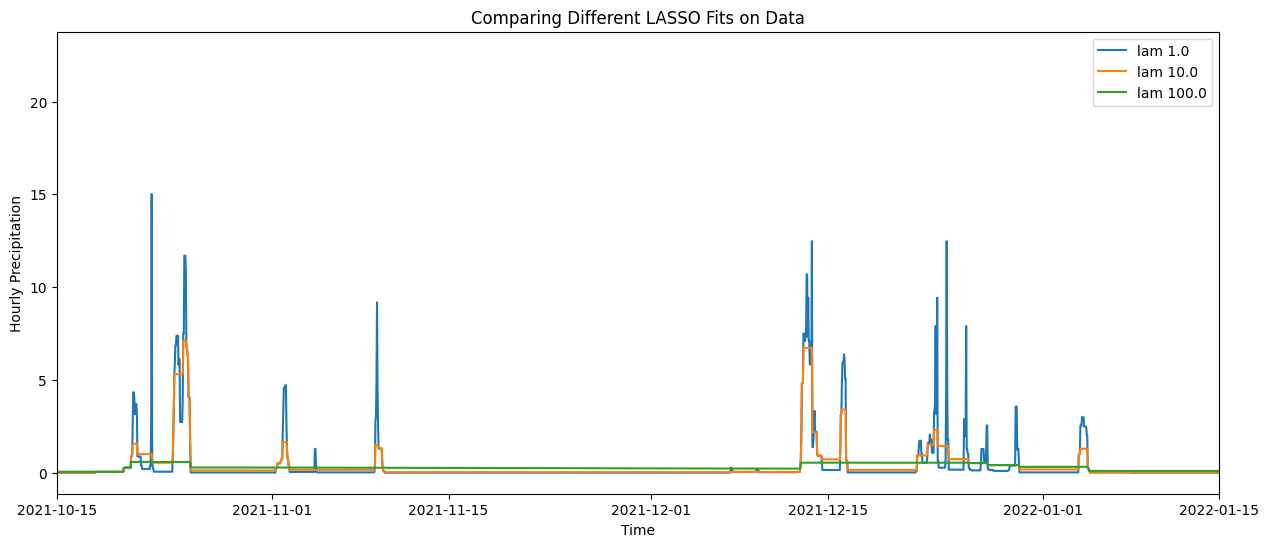

In [40]:
# repeat previous plot with rescaled x-axis
plt.figure(figsize = (15, 6))
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_lasso_1), label="lam 1.0")
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_lasso_10), label="lam 10.0")
plt.plot(t_XOIC1, np.exp(eta_hat_XOIC1_lasso_100), label="lam 100.0")
#plt.plot(t_XOIC1, y_clean_XOIC1, label="clean data")
plt.xlim(pd.Timestamp("2021-10-15"), pd.Timestamp("2022-01-15"))
plt.xlabel('Time')
plt.ylabel('Hourly Precipitation')
plt.title('Comparing Different LASSO Fits on Data')
plt.legend()
plt.show()

In [8]:
def cross_validate_lambda(y, obs_mask, lambdas, k=5, mask_fraction=0.1, penalty='ridge', random_state=None):
    """
    Performs k-fold cross-validation to select the optimal regularization strength (lambda)
    for a penalized Poisson regression smoothing model.

    Parameters:
        y (np.ndarray): Target variable (e.g., hourly precipitation).
        obs_mask (np.ndarray): Boolean mask of observed (non-missing) values.
        lambdas (list or np.ndarray): List of lambda values to evaluate.
        k (int): Number of folds in cross-validation.
        mask_fraction (float): Fraction of observed values to hold out per fold.
        penalty (str): Regularization type ('ridge' or 'lasso').
        random_state (int or None): Seed for reproducibility.

    Returns:
        List of tuples: (index, lambda value, average deviance loss), sorted by loss.
    """
    rng = np.random.default_rng(random_state)
    results = []

    # get indices of observed data points
    observed_idx = np.where(obs_mask)[0]

    # loop over each lambda value
    for l, lam in enumerate(lambdas):
        losses = []

        # perform k-fold cross-validation
        for i in range(k):
            y_masked = y.copy()

            # randomly select a subset of observed indices to mask as test data
            mask_idx = rng.choice(observed_idx, size=int(mask_fraction * len(observed_idx)), replace=False)

            # construct a boolean mask with the selected test indices masked out
            mask_bool = np.zeros_like(y, dtype=bool)
            mask_bool[mask_idx] = True
            comb_mask = (obs_mask & ~mask_bool) # combined mask for training data

            # fit penalized Poisson smoothing model using training data
            eta_hat = fit_poisson_smooth(y_masked, comb_mask, penalty=penalty, lam=lam)
            theta_hat = np.exp(eta_hat)

            # evaluate Poisson deviance on the held-out (masked) points
            y_true = y[mask_idx]
            theta_pred = theta_hat[mask_idx]
            deviance = 2 * np.sum(theta_pred - y_true + y_true * np.log((y_true + 1e-8) / theta_pred))

            losses.append(deviance)
            print(i, end=" ")

        # store average deviance for this lambda
        avg_loss = np.mean(losses)
        results.append((l, lam, avg_loss))
        print("|", end=" ")
        print(l, "\t", np.round(lam, 4), "\t", np.round(avg_loss, 4))

    # return lambdas sorted by average deviance (ascending)
    return sorted(results, key=lambda x: x[2])

In [9]:
# set aside 10% of valid (observed) indices as a test set
test_split = 0.1
XOIC1_idx = np.where(XOIC1_mask)[0] # indices of observed values
rng = np.random.default_rng(42)
test_idx = rng.choice(XOIC1_idx, size=int(test_split * len(XOIC1_idx)), replace=False)

# convert test indices to boolean mask
test_mask = np.zeros_like(y_XOIC1, dtype=bool)
test_mask[test_idx] = True

# define training mask as all observed values not in the test set
train_mask = (XOIC1_mask & ~test_mask)

In [10]:
# define log-spaced grid of lambda values for cross validation
lambdas = np.logspace(-2, 2, 20)
lambdas

array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])

In [ ]:
# run 5-fold cross validation on ridge penalty
cv_train_ridge = cross_validate_lambda(y_clean_XOIC1, train_mask, lambdas, k=5, penalty='ridge', random_state=42)

Kernel died and restarted. The printed output:
```
0 1 2 3 4 | 0 	 0.01 	 245.5713
0 1 2 3 4 | 1 	 0.0162 	 212.9259
0 1 2 3 4 | 2 	 0.0264 	 279.0931
0 1 2 3 4 | 3 	 0.0428 	 252.426
0 1 2 3 4 | 4 	 0.0695 	 279.9462
0 1 2 3 4 | 5 	 0.1129 	 215.8328
0 1 2 3 4 | 6 	 0.1833 	 272.3357
0 1 2 3 4 | 7 	 0.2976 	 222.7845
0 1 2 3 4 | 8 	 0.4833 	 259.1054
0 1 2 3 4 | 9 	 0.7848 	 281.8664
0 1 2 3 4 | 10 	 1.2743 	 307.5153
0 1 2 3 4 | 11 	 2.0691 	 312.3122
0 1 2 3 4 | 12 	 3.3598 	 343.3779
0 1 2 3 4 | 13 	 5.4556 	 394.434
0 1 2 3 4 | 14 	 8.8587 	 327.6993
0 1 2 3 4 | 15 	 14.3845 	 417.7754
0 1 2 3 4 | 16 	 23.3572 	 483.7403
0 1 2 3 4 | 17 	 37.9269 	 470.7328
0 1 2 3 4 | 18 	 61.5848 	 587.5494
0 1 2 3
```

In [11]:
# define second set of lambdas to also search 
lambdas2 = np.logspace(-3, 1, 20)[:5]
lambdas2

array([0.001     , 0.00162378, 0.00263665, 0.00428133, 0.00695193])

In [17]:
# rerun 5-fold cross validation on lambdas2
cv_train_ridge = cross_validate_lambda(y_clean_XOIC1, train_mask, lambdas2, k=5, penalty='ridge', random_state=42)

/accounts/grad/connormc/.local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0 1 2 3 4 | 0 	 0.001 	 309.2614
0 1 2 3 4 | 1 	 0.0016 	 267.814
0 1 2 3 4 | 2 	 0.0026 	 339.9022
0 1 2 3 4 | 3 	 0.0043 	 305.367
0 1 2 3 4 | 4 	 0.007 	 339.4956


In [12]:
# since the two best performing lambda values had similar loss but are an
# order of magnitude apart, we will fit both
lam1 = lambdas[1] # second smallest lambda from first grid
lam5 = lambdas[5] # sixth smallest lambda from first grid

# fit final Poisson smoothing models using these two lambdas
eta_hat_1 = fit_poisson_smooth(y_clean_XOIC1, train_mask, penalty="ridge", lam=lam1)
eta_hat_5 = fit_poisson_smooth(y_clean_XOIC1, train_mask, penalty="ridge", lam=lam5)

In [13]:
# exponentiate eta hat to get theta hat
theta_hat_1 = np.exp(eta_hat_1)
theta_hat_5 = np.exp(eta_hat_5)

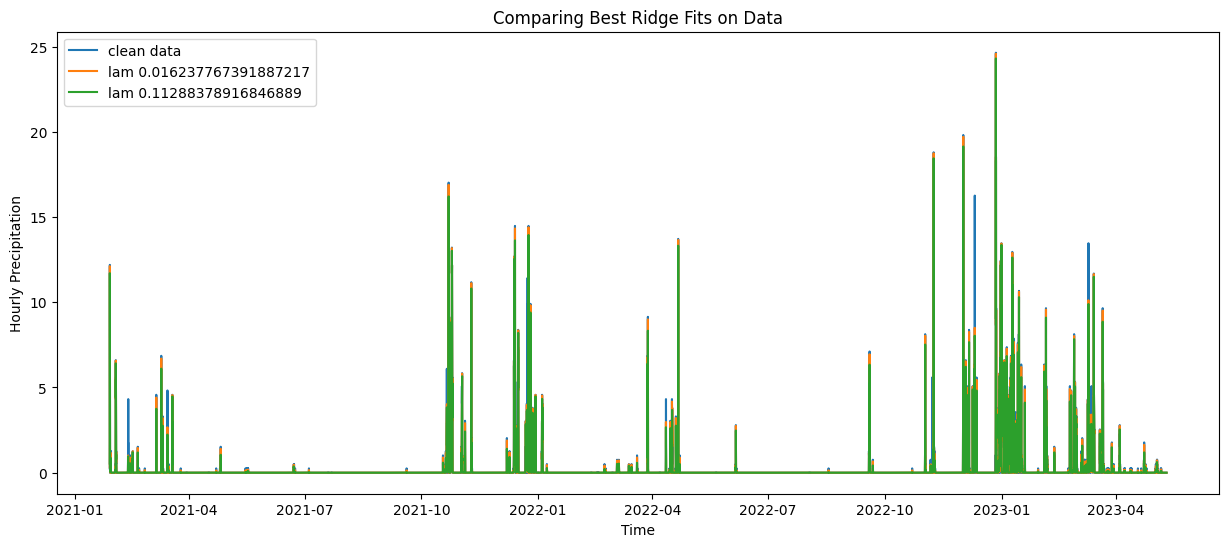

In [14]:
# plot full time series with the two fitted models
plt.figure(figsize = (15, 6))
plt.plot(t_XOIC1, y_clean_XOIC1, label="clean data")
plt.plot(t_XOIC1, theta_hat_1, label=f"lam {lam1}")
plt.plot(t_XOIC1, theta_hat_5, label=f"lam {lam5}")
plt.xlabel('Time')
plt.ylabel('Hourly Precipitation')
plt.title('Comparing Best Ridge Fits on Data')
plt.legend()
plt.show()

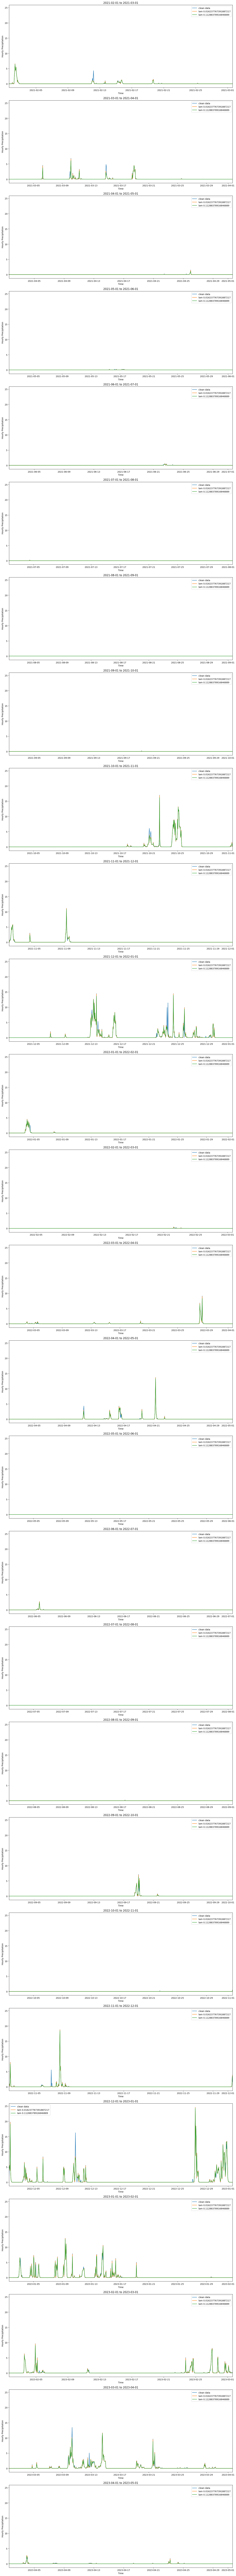

In [32]:
# determine the time range of the data
start = t_XOIC1.min()
end = t_XOIC1.max()

# create a series of timestamps marking the start of each month
date_ranges = pd.date_range(start=start, end=end, freq='1MS')  # 'nMS' = every n months start

# create subplots for each month to visually compare model performance
n_subplots = len(date_ranges) - 1
fig, axs = plt.subplots(n_subplots, 1, figsize=(15, 6 * n_subplots), sharey=True)

for i in range(n_subplots):
    ax = axs[i]
    start_date = date_ranges[i]
    end_date = date_ranges[i + 1]

    # plot original and fitted data for the given month
    ax.plot(t_XOIC1, y_clean_XOIC1, label="clean data")
    ax.plot(t_XOIC1, theta_hat_1, label=f"lam {lam1}")
    ax.plot(t_XOIC1, theta_hat_5, label=f"lam {lam5}")
    ax.set_xlim(start_date, end_date)
    ax.set_xlabel("Time")
    ax.set_ylabel("Hourly Precipitation")
    ax.set_title(f"{start_date.date()} to {end_date.date()}")
    ax.legend()

# prevent overlapping subplots
plt.tight_layout()
plt.show()

In [15]:
def loss(y, theta_hat, mask):
    """
    Compute performance metrics for predicted precipitation values against observed data.

    Parameters
    ----------
    y : np.ndarray
        Array of observed (true) precipitation values.
    theta_hat : np.ndarray
        Array of predicted precipitation values (e.g., from a Poisson model).
    mask : np.ndarray (boolean)
        Boolean array indicating the test set (True for test samples, False otherwise).

    Returns
    -------
    dict
        A dictionary containing the following evaluation metrics:
        - 'deviance': Poisson deviance (lower is better)
        - 'mse': Mean squared error
        - 'rmse': Root mean squared error
        - 'mae': Mean absolute error
        - 'cls_err': Classification error for "wet" events (≥ 0.01 inches)
        - 'tpr': True positive rate (sensitivity) for detecting "wet" hours
        - 'tnr': True negative rate (specificity) for detecting "dry" hours
    """
    # select only test set values
    y_true = y[mask]
    theta_pred = theta_hat[mask]

    # compute Poisson deviance
    deviance = 2 * np.sum(theta_pred - y_true + y_true * np.log((y_true + 1e-8) / theta_pred))

    # compute standard regression metrics
    mse = np.mean((y_true - theta_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - theta_pred))

    # classification error for predicting "wetness" (> 0.01 inches)
    wet_thresh = 0.01 * 25.4 # mm to inches
    ind_true = (y_true >= wet_thresh)
    ind_pred = (theta_pred >= wet_thresh)
    cls_err = np.mean(ind_true != ind_pred)

    # compute confusion matrix components
    nTP = np.sum(ind_true & ind_pred)
    nFP = np.sum(~ind_true & ind_pred)
    nTN = np.sum(~ind_true & ~ind_pred)
    nFN = np.sum(ind_true & ~ind_pred)

    # TPR (sensitivity)
    TPR = nTP / (nTP + nFN) if (nTP + nFN) > 0 else np.nan

    # TNR (specificity)
    TNR = nTN / (nTN + nFP) if (nTN + nFP) > 0 else np.nan

    # return all metrics in a dictionary
    return {"deviance": deviance, "mse": mse, "rmse": rmse, "mae": mae,
            "cls_err": cls_err, "tpr": TPR, "tnr": TNR}

In [16]:
# evaluate loss on full test set for both ridge fits
loss_1 = loss(y_clean_XOIC1, theta_hat_1, test_mask)
loss_5 = loss(y_clean_XOIC1, theta_hat_5, test_mask)

# print loss metrics for each lambda
print(f"lam {np.round(lam1, 3)}:")
pprint(loss_1)

print(f"lam {np.round(lam5, 3)}:")
pprint(loss_5)

lam 0.016:
{'cls_err': 0.02007024586051179,
 'deviance': 262.63239284740354,
 'mae': 0.07929035219006475,
 'mse': 0.2653658180269705,
 'rmse': 0.5151366983888553,
 'tnr': 0.9946808510638298,
 'tpr': 0.7345132743362832}
lam 0.113:
{'cls_err': 0.019066733567486203,
 'deviance': 260.51931347273967,
 'mae': 0.08274152662239367,
 'mse': 0.2691394698322441,
 'rmse': 0.5187865359010815,
 'tnr': 0.9936170212765958,
 'tpr': 0.7699115044247787}


In [17]:
# evaluate loss only on nonzero ("wet") observations in the test set
test_mask_nonzero = (y_clean_XOIC1 != 0) & test_mask
loss_1_nonzero = loss(y_clean_XOIC1, theta_hat_1, test_mask_nonzero)
loss_5_nonzero = loss(y_clean_XOIC1, theta_hat_5, test_mask_nonzero)

print(f"lam {np.round(lam1, 3)}:")
pprint(loss_1_nonzero)

print(f"lam {np.round(lam5, 3)}:")
pprint(loss_5_nonzero)

lam 0.016:
{'cls_err': 0.26548672566371684,
 'deviance': 229.81437548155554,
 'mae': 1.2532448073617262,
 'mse': 4.329516221615391,
 'rmse': 2.080748956893981,
 'tnr': nan,
 'tpr': 0.7345132743362832}
lam 0.113:
{'cls_err': 0.23008849557522124,
 'deviance': 214.962838716987,
 'mae': 1.2577488954031353,
 'mse': 4.393343090673709,
 'rmse': 2.0960303172124464,
 'tnr': nan,
 'tpr': 0.7699115044247787}


In [79]:
# evaluate loss only on zero "dry" observations in the test set
test_mask_zero = (y_clean_XOIC1 == 0) & test_mask
loss_1_zero = loss(y_clean_XOIC1, theta_hat_1, test_mask_zero)
loss_5_zero = loss(y_clean_XOIC1, theta_hat_5, test_mask_zero)

print(f"lam {np.round(lam1, 3)}:")
pprint(loss_1_zero)

print(f"lam {np.round(lam5, 3)}:")
pprint(loss_5_zero)

lam 0.016:
{'cls_err': 0.005319148936170213,
 'deviance': 32.81801736584792,
 'mae': 0.008728196107938277,
 'mse': 0.02108443738575164,
 'rmse': 0.14520481185467526,
 'tnr': 0.9946808510638298,
 'tpr': nan}
lam 0.113:
{'cls_err': 0.006382978723404255,
 'deviance': 45.5564747557526,
 'mae': 0.012116083711636331,
 'mse': 0.02124850751570923,
 'rmse': 0.14576867810235924,
 'tnr': 0.9936170212765958,
 'tpr': nan}


In [21]:
# compare to baseline: neighbor station mean predictions
mean_neighbor_loss = loss(y_clean_XOIC1, mean_neighbor_clean, test_mask)

print(f"neighbor mean:")
pprint(mean_neighbor_loss)

neighbor mean:
{'cls_err': 0.04565980933266432,
 'deviance': nan,
 'mae': 0.12471590566984445,
 'mse': 0.5587652579227295,
 'rmse': 0.7475060253420901,
 'tnr': 0.9893617021276596,
 'tpr': 0.37168141592920356}


/tmp/ipykernel_680274/4133985223.py:7: RuntimeWarning: divide by zero encountered in divide
  deviance = 2 * np.sum(theta_pred - y_true + y_true * np.log((y_true + 1e-8) / theta_pred))
/tmp/ipykernel_680274/4133985223.py:7: RuntimeWarning: invalid value encountered in multiply
  deviance = 2 * np.sum(theta_pred - y_true + y_true * np.log((y_true + 1e-8) / theta_pred))


In [77]:
def plot_test_losses(losses, labels, colors=None):
    """
    Plot horizontal bar charts for various evaluation metrics from different models or baselines.

    Parameters:
    ----------
    losses : List[Dict[str, float]]
        A list of dictionaries, where each dictionary corresponds to the performance metrics
        of a model or baseline. Each dictionary can contain the following keys:
        "deviance", "mse", "rmse", "mae", "cls_err", "tpr", "tnr".

    labels : List[str]
        A list of string labels corresponding to each loss dictionary in the `losses` list.

    colors : Optional[List[str]]
        A list of color strings to use for the bars corresponding to each entry in `losses`.
        If None, all bars will be blue by default.
    """
    if colors is None:
        colors = ["blue"] * len(losses)

    # define the metrics to plot and their display labels
    metrics = ["deviance", "mse", "rmse", "mae", "cls_err", "tpr", "tnr"]
    metric_labels = ["Deviance", "MSE", "RMSE", "MAE", "Class. Error", "TPR", "TNR"]
    num_metrics = len(metrics)

    # create subplot gird to fit all metrics (2 columns)
    fig, axes = plt.subplots(
        nrows=math.ceil(num_metrics / 2),
        ncols=2,
        figsize=(12, 4 * math.ceil(num_metrics / 2))
    )
    axes = axes.flatten() # flatten 2D array to simplify iteration

    # plot each metric as a horizontal bar chart
    for i, metric in enumerate(metrics):
        # extract metric values across all models/loss dictionaries
        values = [loss.get(metric, np.nan) for loss in losses]
        values = [np.nan if v is None else v for v in values]
        
        ax = axes[i]
        y_pos = np.arange(len(labels)) # y-position for bars
        bar_height = 0.3  # thin bars

        bars = ax.barh(y_pos, values, height=bar_height)

        # set axis titles and tick labels
        ax.set_title(metric_labels[i])
        ax.set_xlabel(metric_labels[i])
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels)
        ax.invert_yaxis()  # top-to-bottom ordering

        # apply custom colors
        for bar, color in zip(bars, colors):
            bar.set_edgecolor(color)
            bar.set_facecolor(color)

        # handle nan values visually
        for bar, val in zip(bars, values):
            if np.isnan(val):
                bar.set_width(0)
                bar.set_alpha(0.3)
                bar.set_edgecolor("gray")
                bar.set_facecolor("lightgray")

    # remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

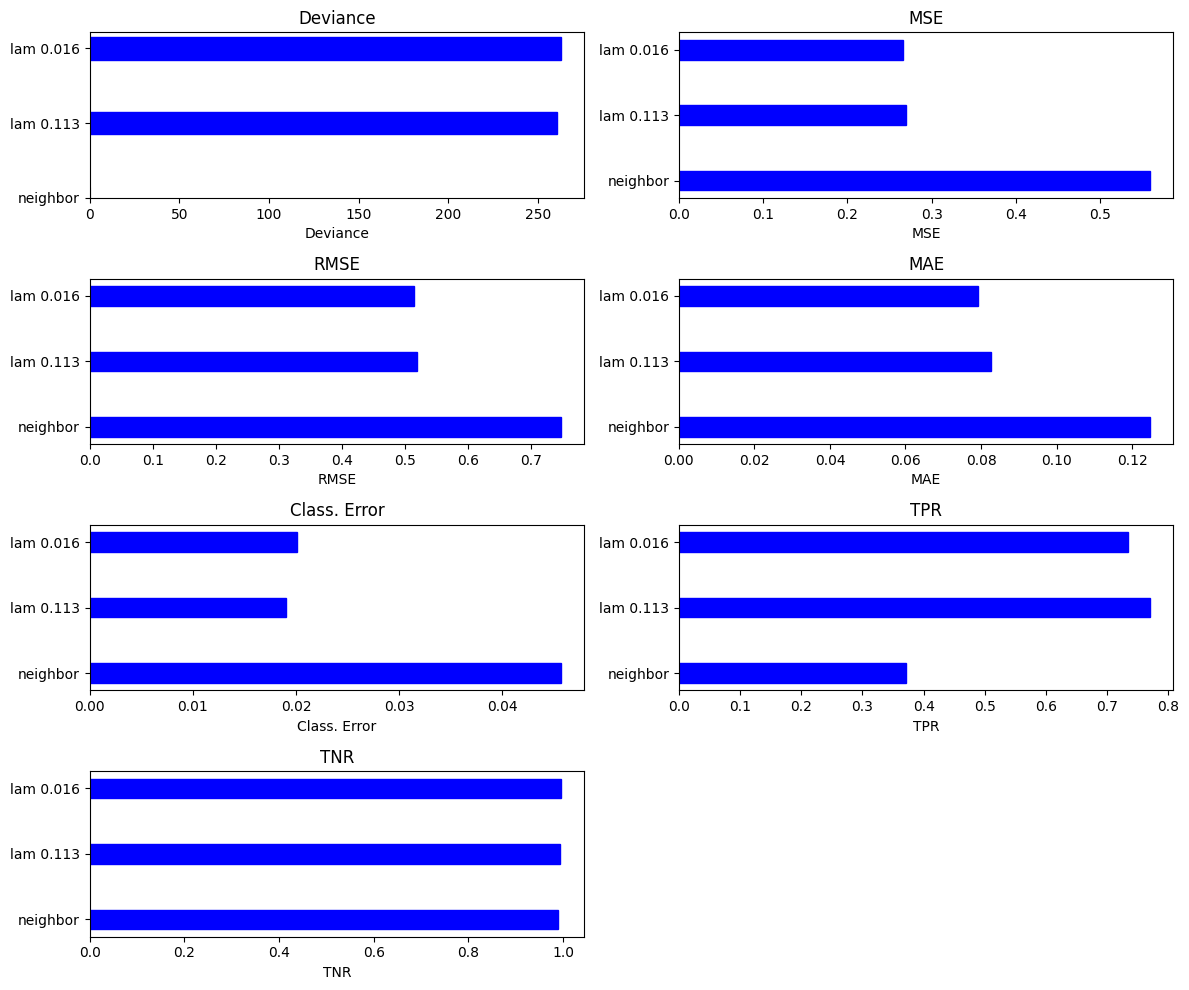

In [65]:
# plot performance comparison for two ridge models and 
# neighbor mean baseline
plot_test_losses(
    [loss_1, loss_5, mean_neighbor_loss],
    ["lam 0.016", "lam 0.113", "neighbor"]
)

In [44]:
def sequential_train_test_split(test_split, n, y_mask, random_number=42):
    """
    Generate train and test masks from a boolean mask, ensuring test indices consist of contiguous sequences.

    Parameters:
        test_split (float): Proportion of valid indices to include in the test set (0 < test_split < 1).
        n (int): Length of contiguous sequences to sample for the test set.
        y_mask (np.ndarray): Boolean array indicating valid indices to sample from.
        random_number (int): Seed for random number generator.

    Returns:
        test_mask (np.ndarray): Boolean array with test indices marked as True.
        test_idx (np.ndarray): Indices included in the test set.
        train_mask (np.ndarray): Boolean array with train indices marked as True.
        train_idx (np.ndarray): Indices included in the training set.
    """
    assert 0 < test_split < 1, "test_split must be between 0 and 1"
    assert n >= 1, "n must be at least 1"
    
    y_mask = np.asarray(y_mask, dtype=bool)
    valid_idx = np.where(y_mask)[0]
    valid_idx_set = set(valid_idx)

    # identify all valid starting indices where an entire length-n
    # secquence fits within valid_idx
    valid_starts = []
    for i in valid_idx:
        if all((i + j) in valid_idx_set for j in range(n)):
            valid_starts.append(i)

    # eliminate overlapping sequences 
    valid_starts.sort()
    non_overlapping_starts = []
    used = set()
    for start in valid_starts:
        if all((start + j) not in used for j in range(n)):
            non_overlapping_starts.append(start)
            used.update(start + j for j in range(n))

    # choose number of sequences to include in test set
    num_test_sequences = int((test_split * len(valid_idx)) // n)
    rng = np.random.default_rng(random_number)
    sampled_starts = rng.choice(non_overlapping_starts, size=num_test_sequences, replace=False)

    # flatten sampled sequences into array of test indices
    test_idx = np.concatenate([np.arange(s, s + n) for s in sampled_starts])

    # create boolean test and train masks
    test_mask = np.zeros_like(y_mask, dtype=bool)
    test_mask[test_idx] = True
    train_mask = y_mask & ~test_mask
    train_idx = np.where(train_mask)[0]

    return test_mask, test_idx, train_mask, train_idx


In [49]:
def sequential_fit(nlist, y, obs_mask, lam=1.0, test_split=0.1, random_number=42):
    """
    Fit Poisson regression models for different sequence lengths using smoothed training data.

    Parameters:
        nlist (List[int]): List of sequence lengths for generating training/test splits.
        y (np.ndarray): Observed count data.
        obs_mask (np.ndarray): Boolean array indicating observed (valid) entries.
        lam (float): Regularization strength for Poisson smoothing.
        test_split (float): Proportion of observed data to use for testing.
        random_number (int): Seed for reproducibility.

    Returns:
        List[np.ndarray]: List of fitted log-rates (eta) for each value of n in nlist.
    """
    results = []
    for n in nlist:
        _, _, train_mask, _ = sequential_train_test_split(test_split, n, obs_mask, random_number=42)
        eta_fit_n = fit_poisson_smooth(y, train_mask, penalty="ridge", lam=lam)
        results.append(eta_fit_n)
    return results

In [69]:
# fit models across multiple sequence lengths
seq_fits_1 = sequential_fit([2, 6, 12, 24, 48], y_clean_XOIC1, XOIC1_mask, lam=lam1)
seq_fits_5 = sequential_fit([2, 6, 12, 24, 48], y_clean_XOIC1, XOIC1_mask, lam=lam5)

/accounts/grad/connormc/.local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [70]:
# define the sequence lengths
nlist = [2, 6, 12, 24, 48]

# generate test masks for each sequence length
test_mask_list = [sequential_train_test_split(0.1, n, XOIC1_mask)[0] for n in nlist]

In [71]:
# initialize lists for losses, labels, and colors for plotting 
loss_list = [loss_1, loss_5, mean_neighbor_loss]
lab_list = ["lam 0.016, n=1", "lam 0.113, n=1", "neighbor, n=1"]
color_list = ["green"]*3
colors = ["blue", "purple", "red", "orange", "brown"]

# evaluate each model (and neighbor baseline) on the corresponding test set
for i, n in enumerate(nlist):
    color = colors[i]
    test_mask_i = test_mask_list[i]
    
    eta_hat_1_i = seq_fits_1[i]
    eta_hat_5_i = seq_fits_1[i]

    theta_hat_1_i = np.exp(eta_hat_1_i)
    theta_hat_5_i = np.exp(eta_hat_5_i)

    loss_1_i = loss(y_clean_XOIC1, theta_hat_1_i, test_mask_i)
    loss_5_i = loss(y_clean_XOIC1, theta_hat_5_i, test_mask_i)
    loss_neighbor_i = loss(y_clean_XOIC1, mean_neighbor_clean, test_mask_i)

    lab_1_i = f"lam 0.016, n={n}"
    lab_5_i = f"lam 0.113, n={n}"
    lab_neighbor_i = f"neighbor, n={n}"

    loss_list.append(loss_1_i)
    loss_list.append(loss_5_i)
    loss_list.append(loss_neighbor_i)

    lab_list.append(lab_1_i)
    lab_list.append(lab_5_i)
    lab_list.append(lab_neighbor_i)

    color_list.append(color)
    color_list.append(color)
    color_list.append(color)

/tmp/ipykernel_680274/4133985223.py:7: RuntimeWarning: divide by zero encountered in divide
  deviance = 2 * np.sum(theta_pred - y_true + y_true * np.log((y_true + 1e-8) / theta_pred))
/tmp/ipykernel_680274/4133985223.py:7: RuntimeWarning: invalid value encountered in multiply
  deviance = 2 * np.sum(theta_pred - y_true + y_true * np.log((y_true + 1e-8) / theta_pred))


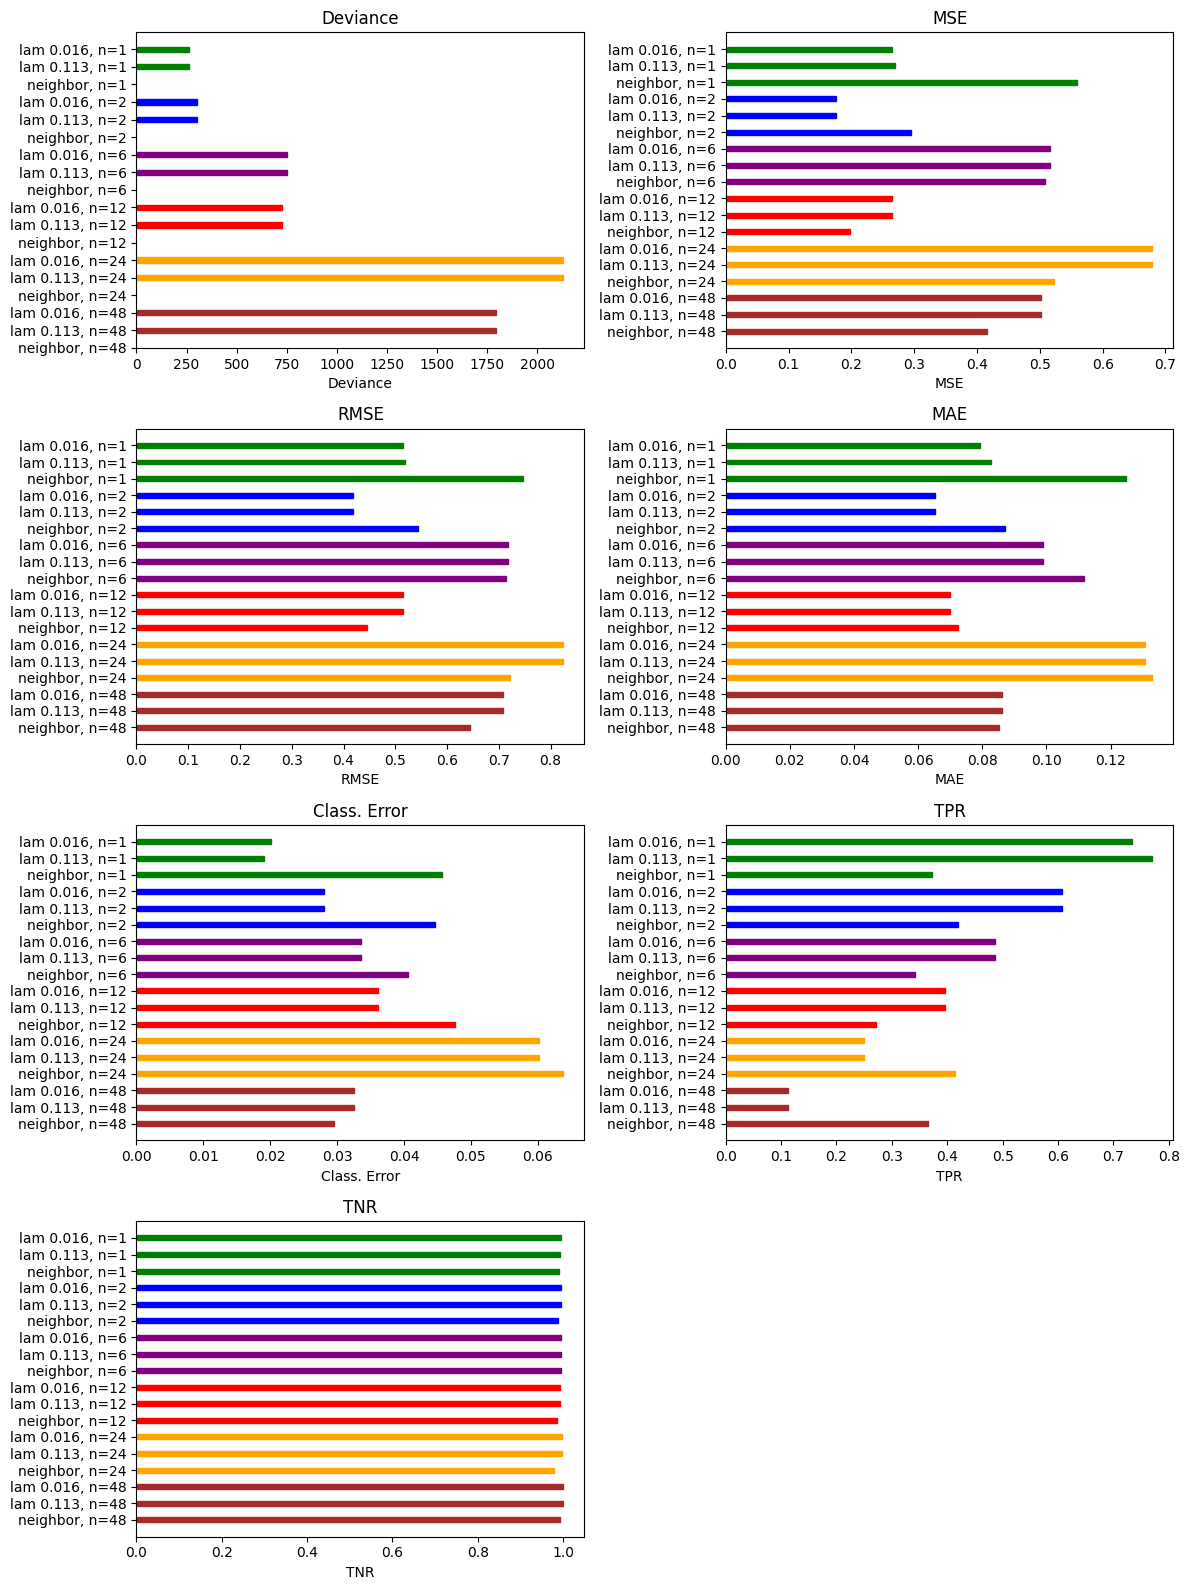

In [78]:
# plot all collected losses with labels and color coding
plot_test_losses(loss_list, lab_list, color_list)

### Part 2: Uncertainty Quantification for "KNNC1" Data

In [21]:
# fit a Poisson model with ridge penalty to the first year (8760 hours)
# of cleaned KNNC1 data
eta_hat_KNNC1 = fit_poisson_smooth(y_clean_KNNC1[:8760], KNNC1_mask, penalty="ridge", lam=10.0)

In [22]:
# convert eta hat to theta hat
theta_hat_KNNC1 = np.exp(eta_hat_KNNC1)

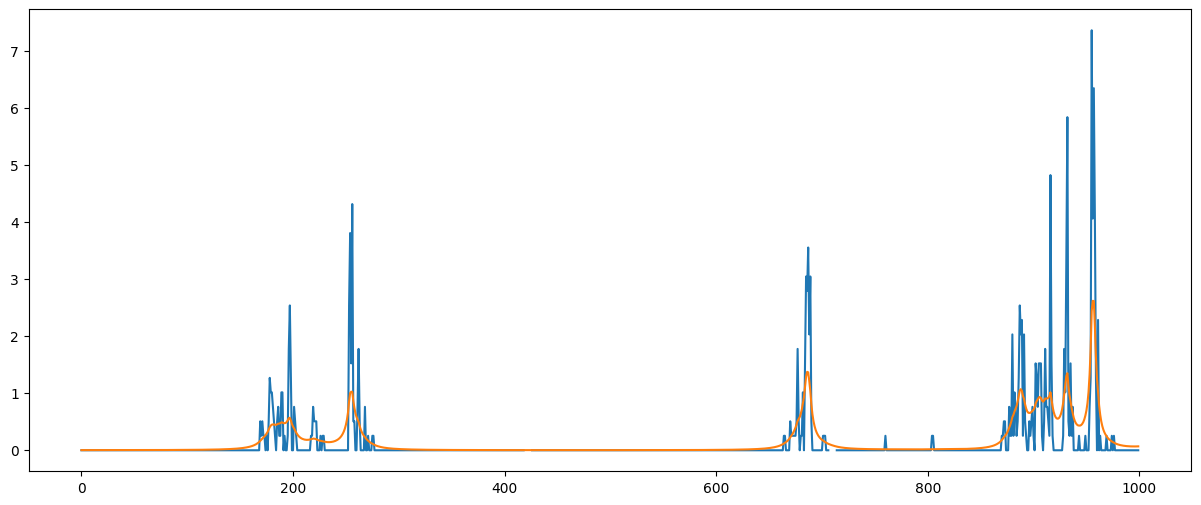

In [23]:
# plot actual vs. fitted values for the first 1000 hours to
# better visualize model fit
plt.figure(figsize = (15, 6))
plt.plot(y_clean_KNNC1[:1000])
plt.plot(theta_hat_KNNC1[:1000])
plt.show()

In [10]:
# generate a log-spaced lambda grid (same as the first)
lambdas = np.logspace(-2, 2, 20)
lambdas

array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])

In [49]:
# perform 5-fold cross-validation to selet the best ridge penalty
cv_ridge = cross_validate_lambda(y_clean_KNNC1[:8760], KNNC1_mask, lambdas, k=5, penalty='ridge', random_state=42)

0 1 2 3 4 0 0.01 189.0251
0 1 2 3 4 1 0.0162 222.085
0 1 2 3 4 2 0.0264 183.8471
0 1 2 3 4 3 0.0428 183.2554
0 1 2 3 4 4 0.0695 160.8698
0 1 2 3 4 5 0.1129 210.7597
0 1 2 3 4 6 0.1833 186.954
0 1 2 3 4 7 0.2976 181.4342
0 1 2 3 4 8 0.4833 156.6413
0 1 2 3 4 9 0.7848 180.972
0 1 2 3 4 10 1.2743 201.4509
0 1 2 3 4 11 2.0691 204.6238
0 1 2 3 4 12 3.3598 206.0584
0 1 2 3 4 13 5.4556 262.7286
0 1 2 3 4 14 8.8587 273.895
0 1 2 3 4 15 14.3845 275.0687
0 1 2 3 4 16 23.3572 316.1238
0 1 2 3 4 17 37.9269 325.3771
0 1 2 3 4 18 61.5848 381.0687
0 1 2 3 4 19 100.0 415.9845


In [55]:
# repeat cross-validation for lasso
cv_lasso = cross_validate_lambda(y_clean_KNNC1[:8760], KNNC1_mask, lambdas, k=5, penalty='lasso', random_state=42)

0 1 2 3 4 0 0.01 244.4878
0 1 2 3 4 1 0.0162 329.511
0 1 2 3 4 2 0.0264 244.8691
0 1 2 3 4 3 0.0428 222.3405
0 1 2 3 4 4 0.0695 193.5154
0 1 2 3 4 5 0.1129 249.3046
0 1 2 3 4 6 0.1833 200.4936
0 1 2 3 4 7 0.2976 231.4839
0 1 2 3 4 8 0.4833 170.8718
0 1 2 3 4 9 0.7848 202.231
0 1 2 3 4 10 1.2743 237.5011
0 1 2 3 4 11 2.0691 237.5029
0 1 2 3 4 12 3.3598 268.5083
0 1 2 3 4 13 5.4556 339.0552
0 1 2 3 4 14 8.8587 439.1441
0 1 2 3 4 15 14.3845 450.1599
0 1 2 3 4 16 23.3572 516.8668
0 1 2 3 4 17 37.9269 596.2819
0 1 2 3 4 18 61.5848 656.5879
0 1 2 3 4 19 100.0 702.3919


In [11]:
# select the best lambda for both ridge and lasso
best_lambda_ridge = lambdas[8] #cv_ridge[0][1]
best_lambda_lasso = lambdas[8] #cv_lasso[0][1]

# fit Poisson smoothing using the best lambdas (first year of data)
eta_hat_ridge = fit_poisson_smooth(y_clean_KNNC1[:8760], KNNC1_mask, penalty="ridge", lam=best_lambda_ridge)
eta_hat_lasso = fit_poisson_smooth(y_clean_KNNC1[:8760], KNNC1_mask, penalty="lasso", lam=best_lambda_lasso)

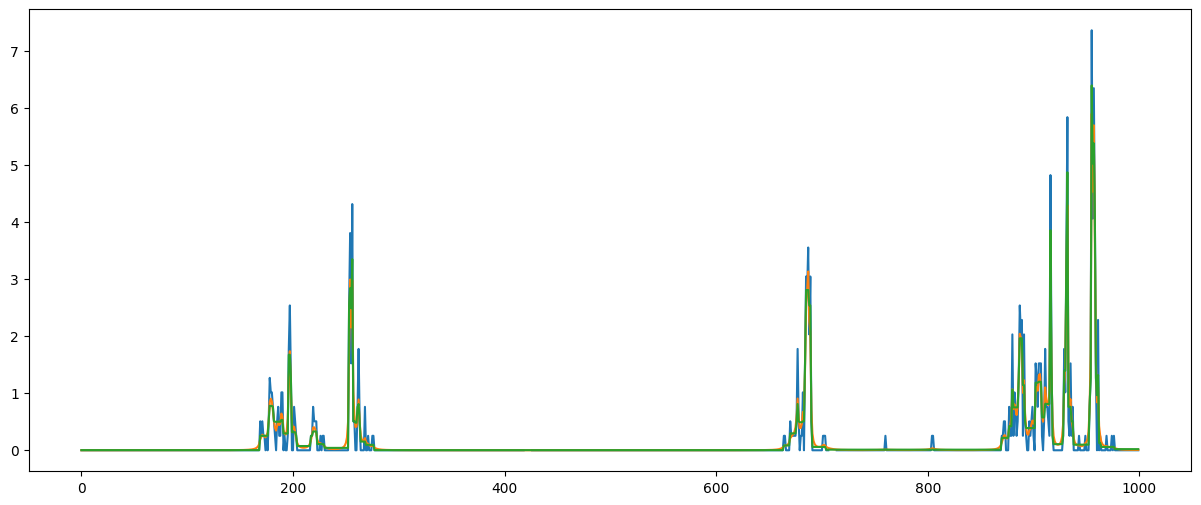

In [12]:
# convert eta hat to theta hat
theta_hat_ridge = np.exp(eta_hat_ridge)
theta_hat_lasso = np.exp(eta_hat_lasso)

# plot the fitted values against the observed data for the first 1000 hours
plt.figure(figsize = (15, 6))
plt.plot(y_clean_KNNC1[:1000])
plt.plot(theta_hat_ridge[:1000])
plt.plot(theta_hat_lasso[:1000])
plt.show()

In [48]:
def compute_eta_se(eta_hat, lam, alpha=0.05):
    """
    Compute standard errors for eta (log-intensity estimates) using the observed Fisher information
    and the penalty Hessian from the ridge-regularized Poisson model.

    Parameters:
        eta_hat (np.ndarray): Estimated log-intensities (η̂).
        lam (float): Regularization parameter (lambda).
        alpha (float): Significance level (default 0.05 for 95% CI).

    Returns:
        np.ndarray: Pointwise standard errors of eta_hat.
    """
    n = len(eta_hat)
    theta_hat = np.exp(eta_hat) # mean estimates under the model

    # fisher information matrix from Poisson likelihood
    H_lik = np.diag(theta_hat)

    # first-order difference matrix (used for smoothness penalty)
    D = np.eye(n) - np.eye(n, k=-1)
    D = D[1:] # remove first row

    # penalty contribution to the Hessian (ridge: lambda * |Dη|^2)
    H_penalty = lam * D.T @ D

    # total (negative) Hessian = likelihood + penalty contribution
    H_total = H_lik + H_penalty

    # invert Hessian for covariance matrix of eta
    cov_eta = inv(H_total)

    # extract standard errors (square roots of diagonal entries)
    se_eta = np.sqrt(np.diag(cov_eta))
    return se_eta

def get_ci(eta_hat, se_eta, alpha=0.05):
    """
    Construct pointwise confidence intervals for η̂ and return them on the intensity (exp) scale.

    Parameters:
        eta_hat (np.ndarray): Estimated log-intensities.
        se_eta (np.ndarray): Standard errors of eta_hat.
        alpha (float): Significance level (default 0.05 for 95% CI).

    Returns:
        Tuple[np.ndarray, np.ndarray]: Lower and upper confidence bounds (exp-transformed).
    """
    scale = norm.ppf(1-alpha/2) # z-score for 1 - alpha/2
    ci_lower = eta_hat - scale * se_eta
    ci_upper = eta_hat + scale * se_eta
    return np.exp(ci_lower), np.exp(ci_upper)

In [ ]:
# compute standard errors from the fitted model
se_eta = compute_eta_se(eta_hat_ridge, best_lambda_ridge)

# construct 95% confidence intervals using normal approximation (Fisher)
ci_fisher_lower, ci_fisher_upper = get_ci(eta_hat_ridge, se_eta, alpha=0.05)

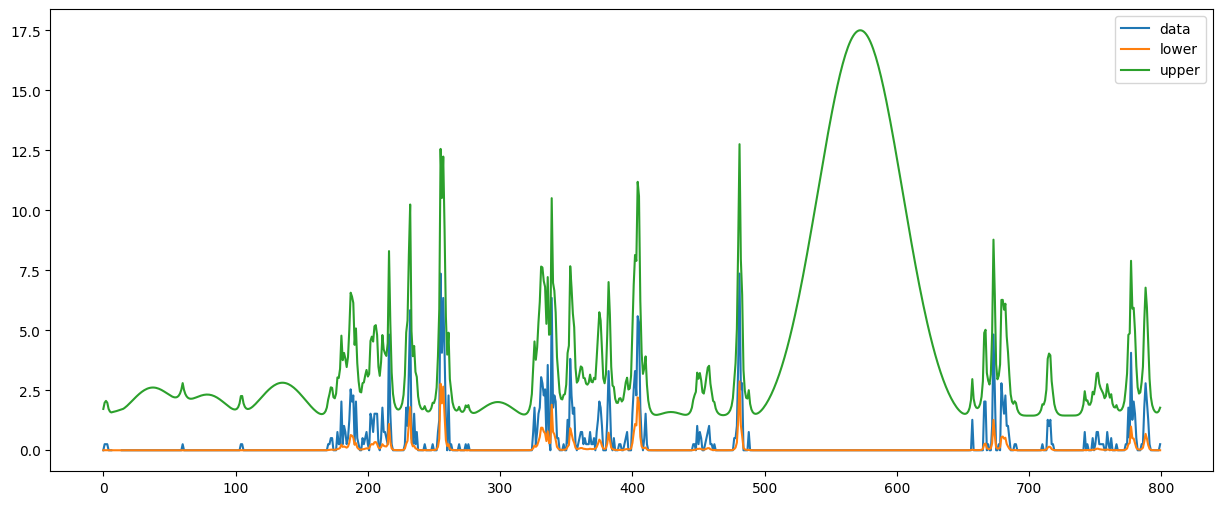

In [84]:
# plot the confidence intervals against the data over an 800 hour slice
plt.figure(figsize = (15, 6))
plt.plot(y_clean_KNNC1[700:1500], label="data")
plt.plot(ci_fisher_lower[700:1500], label="lower")
plt.plot(ci_fisher_upper[700:1500], label="upper")
plt.legend()
plt.show()

In [79]:
def bootstrap_eta(y_obs, obs_mask, lam, B=100):
    """
    Compute bootstrap confidence intervals for η̂ by resampling from the fitted Poisson model.

    Parameters:
        y_obs (np.ndarray): Observed count data.
        lam (float): Regularization parameter for ridge smoothing.
        B (int): Number of bootstrap replicates.
        obs_mask (np.ndarray or None): Optional binary mask for missing values. If None, assume all observed.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Lower CI, upper CI, and all bootstrap η̂ samples.
    """
    n = len(y_obs)
    eta_boot = np.zeros((B, n))

    # fit model onces to get baesline for theta hat
    eta_hat = fit_poisson_smooth(y_obs, obs_mask, penalty="ridge", lam=lam)
    theta_hat = np.exp(eta_hat)

    for b in range(B):
        # resample from Poisson distribution
        y_boot = np.random.poisson(theta_hat)

        # fit model for boostrap replicate b
        boot_mask = np.ones(n, dtype=bool)
        eta_b = fit_poisson_smooth(y_boot, boot_mask, penalty="ridge", lam=lam)
        eta_boot[b, :] = eta_b

    # empirical percentiles for pointwise 95% CIs
    ci_lower = np.percentile(eta_boot, 2.5, axis=0)
    ci_upper = np.percentile(eta_boot, 97.5, axis=0)

    return ci_lower, ci_upper, eta_boot

In [80]:
# compute bootstrap CIs using B=100 replicates
ci_boot_lower, ci_boot_upper, _ = bootstrap_eta(y_clean_KNNC1[:8760], best_lambda_ridge, B=100)

/accounts/grad/connormc/.local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


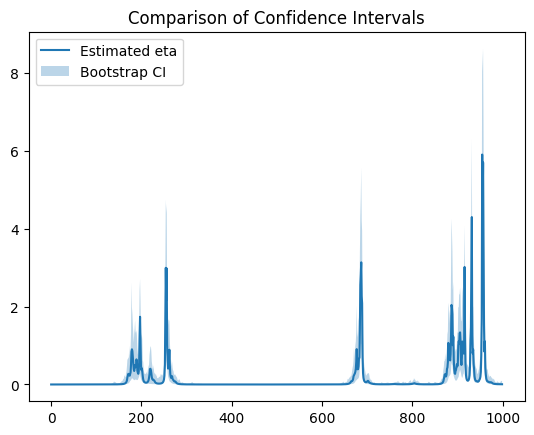

In [89]:
# compare confidence intervals between methods
plt.plot(np.exp(eta_hat_ridge[:1000]), label='Estimated eta')

# fisher interval removed because the standard error explodes
# around sequences of zeros
#plt.fill_between(range(len(eta_hat_ridge[:1000])), ci_fisher_lower[:1000], ci_fisher_upper[:1000], alpha=0.3, label='Fisher CI')

plt.fill_between(range(len(eta_hat_ridge[:1000])), np.exp(ci_boot_lower[:1000]), np.exp(ci_boot_upper[:1000]), alpha=0.3, label='Bootstrap CI')
plt.legend()
plt.title("Comparison of Confidence Intervals")
plt.show()